In [ ]:
# TimeTrans: Transformer Architecture for fMRI Temporal Pattern Analysis
#
# This notebook implements a specialized transformer for analyzing temporal patterns in fMRI data

# Install required packages
!pip install numpy pandas matplotlib seaborn scikit-learn torch nibabel nilearn h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import nibabel as nib
from nilearn import plotting, image, masking
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import math
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/localizer_first_level

[fetch_single_file] Downloading data from https://osf.io/2bqxn/download ...

[_chunk_report_] Downloaded 19841024 of 34532740 bytes (57.5%%,    0.7s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/localizer_first_level/cac0ef0f4307834e60fedd2a0448862a/download...

[uncompress_file] .. done.

Functional image shape: (53, 63, 46, 128)
Event conditions: ['visual_computation' 'horizontal_checkerboard'
 'audio_right_hand_button_press' 'sentence_listening'
 'visual_right_hand_button_press' 'audio_left_hand_button_press'
 'visual_left_hand_button_press' 'vertical_checkerboard'
 'audio_computation' 'sentence_reading']
First few events:
                      trial_type  onset  duration
0             visual_computation    0.0       1.0
1             visual_computation    2.4       1.0
2        horizontal_checkerboard    8.7       1.0
3  audio_right_hand_button_press   11.4       1.0
4             sentence_listening   15.0       1.0
Creating brain mask...
Extracting time series...
Extracted time series shape: (128, 152799)


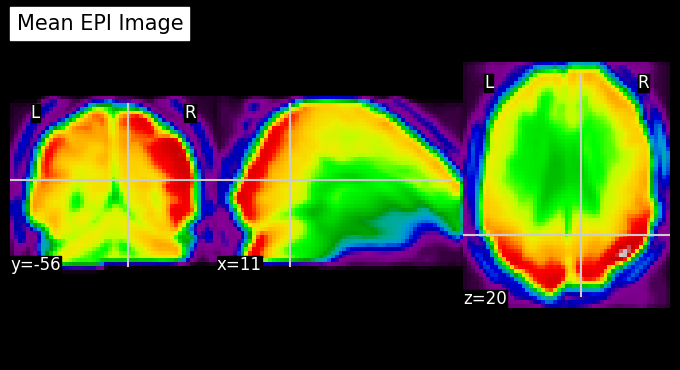

In [ ]:
from nilearn.datasets import fetch_localizer_first_level
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nilearn.input_data import NiftiMasker  # Correct import was here

# Download the Localizer dataset
print("Downloading Localizer dataset...")
localizer = fetch_localizer_first_level()

# Load the functional data
func_file = localizer.epi_img
func_img = nib.load(func_file)
t_r = 2.4  # TR in seconds
print(f"Functional image shape: {func_img.shape}")

# Load events
events = pd.read_table(localizer.events)
print(f"Event conditions: {events['trial_type'].unique()}")
print(f"First few events:\n{events.head()}")

# Create a mask
print("Creating brain mask...")
mask_img = image.math_img('img > 0', img=image.mean_img(func_img))

# Extract time series
print("Extracting time series...")
masker = NiftiMasker(mask_img=mask_img, standardize=True, t_r=t_r)
time_series = masker.fit_transform(func_img)
print(f"Extracted time series shape: {time_series.shape}")

# Visualize
plotting.plot_epi(image.mean_img(func_img), title="Mean EPI Image")
plt.show()

Functional image dimensions: (53, 63, 46, 128)
Number of time points: 128
Number of voxels per volume: 153594
Visualizing mean functional image across time...


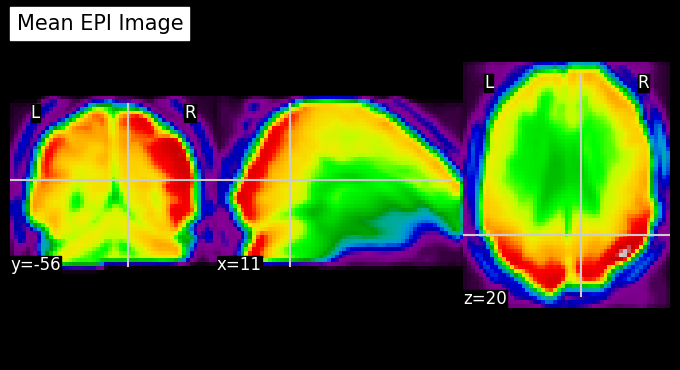

Visualizing brain mask...


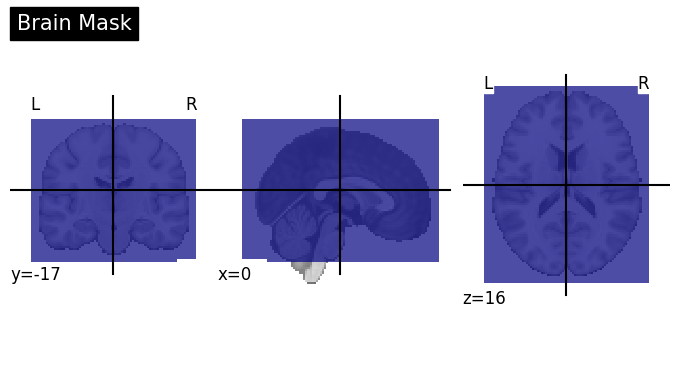


Event statistics:
Total number of events: 80
Event types distribution:
trial_type
visual_computation                10
horizontal_checkerboard           10
sentence_listening                10
sentence_reading                  10
audio_computation                 10
vertical_checkerboard             10
audio_left_hand_button_press       5
visual_right_hand_button_press     5
audio_right_hand_button_press      5
visual_left_hand_button_press      5
Name: count, dtype: int64


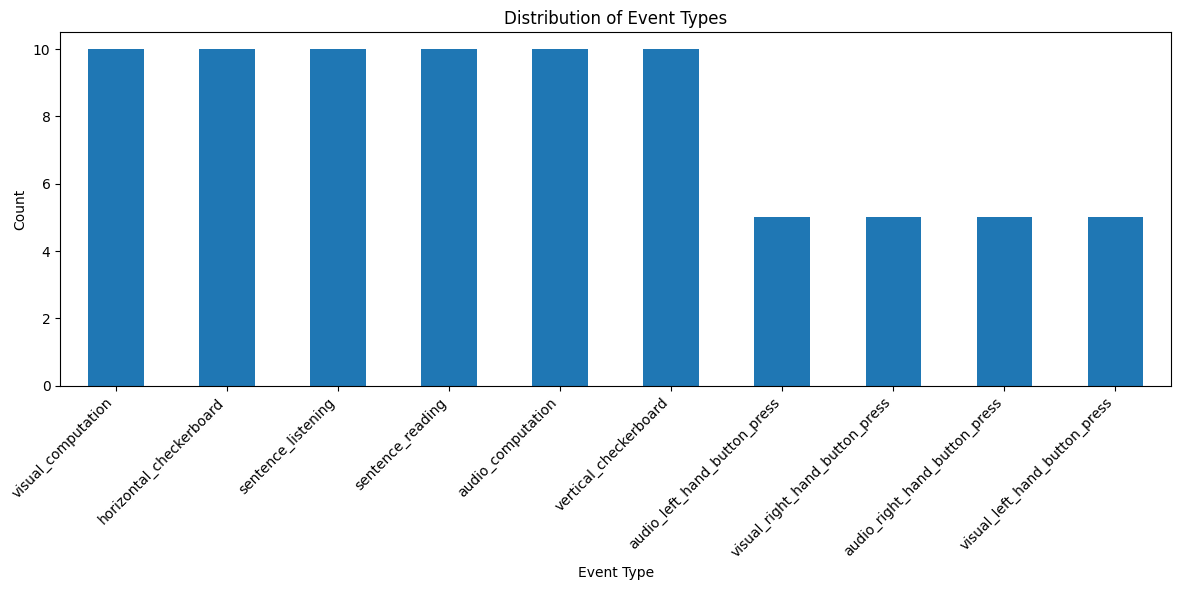

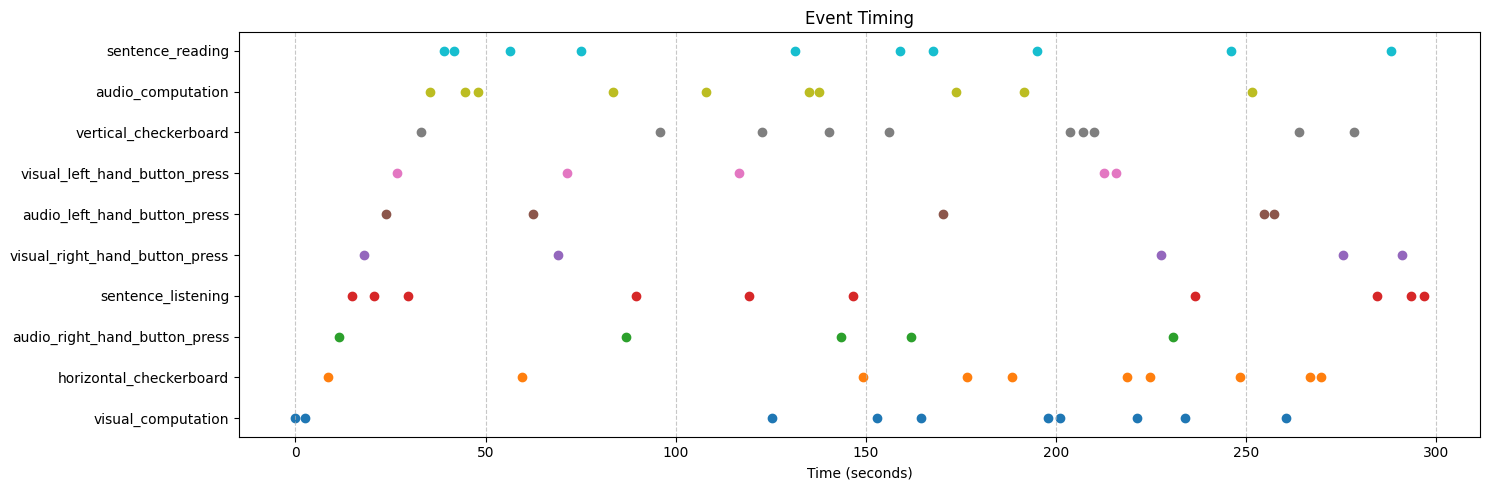


Time series statistics:
Time series shape: (128, 152799)
Mean value: -0.0000
Standard deviation: 0.9984
Min value: -11.2694
Max value: 11.2694


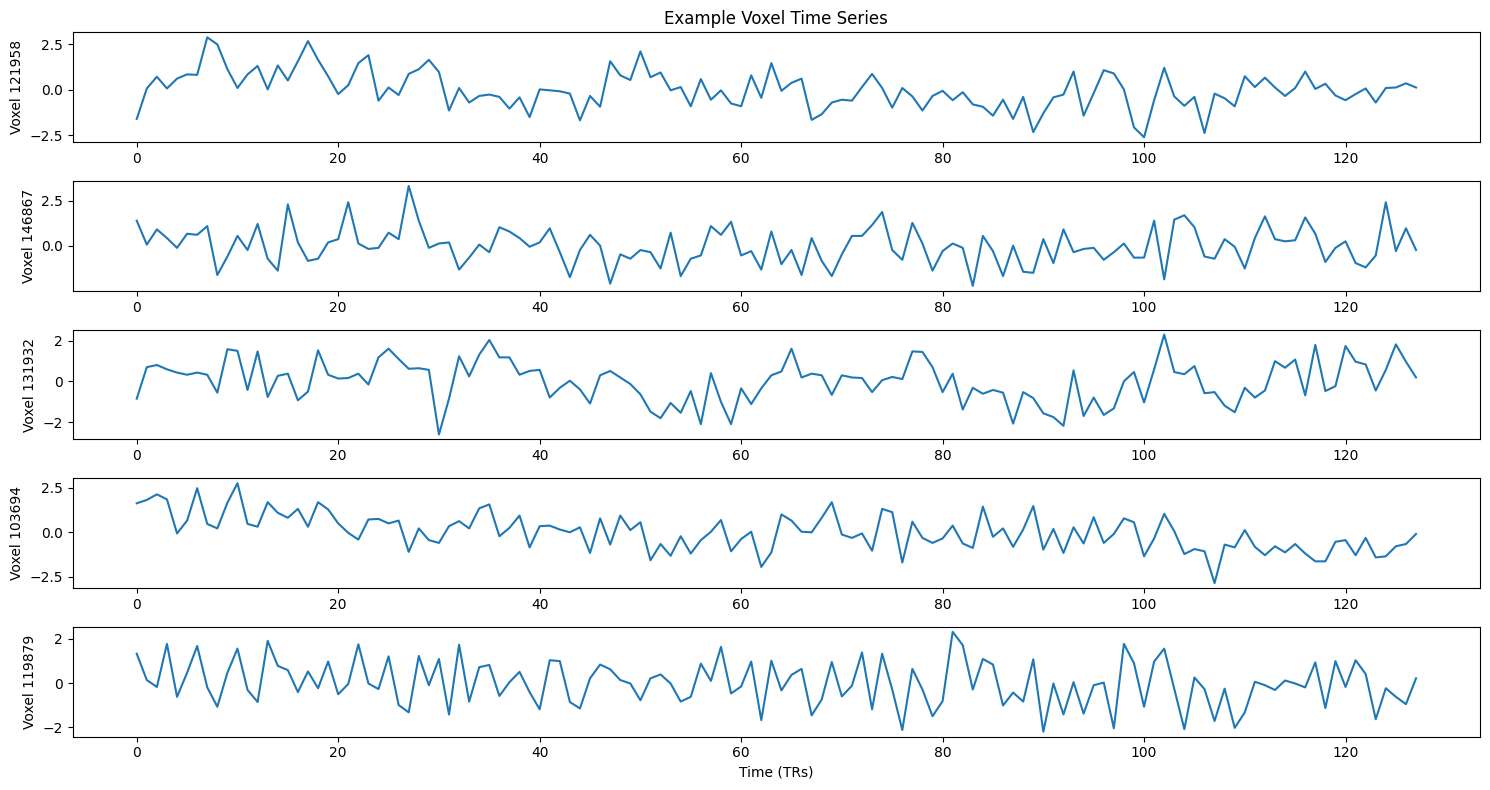

In [ ]:
# Block 3: Data Exploration for Localizer Dataset
#
# This block explores and visualizes the structure of the Localizer fMRI dataset

import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting, image

# Display information about the functional data
print(f"Functional image dimensions: {func_img.shape}")
print(f"Number of time points: {func_img.shape[3]}")
print(f"Number of voxels per volume: {func_img.shape[0] * func_img.shape[1] * func_img.shape[2]}")

# Visualize the mean functional image
mean_img = image.mean_img(func_img)
print("Visualizing mean functional image across time...")
plotting.plot_epi(mean_img, title="Mean EPI Image")
plt.show()

# Visualize the mask
print("Visualizing brain mask...")
plotting.plot_roi(mask_img, title="Brain Mask")
plt.show()

# Explore event structure
print("\nEvent statistics:")
print(f"Total number of events: {len(events)}")
print(f"Event types distribution:")
event_counts = events['trial_type'].value_counts()
print(event_counts)

# Visualize event distribution
plt.figure(figsize=(12, 6))
events['trial_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Event Types')
plt.ylabel('Count')
plt.xlabel('Event Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize event timing
plt.figure(figsize=(15, 5))
for i, event_type in enumerate(events['trial_type'].unique()):
    event_times = events[events['trial_type'] == event_type]['onset'].values
    plt.scatter([t for t in event_times], [i] * len(event_times), label=event_type)
plt.yticks(range(len(events['trial_type'].unique())), events['trial_type'].unique())
plt.xlabel('Time (seconds)')
plt.title('Event Timing')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Explore time series data
print("\nTime series statistics:")
print(f"Time series shape: {time_series.shape}")
print(f"Mean value: {np.mean(time_series):.4f}")
print(f"Standard deviation: {np.std(time_series):.4f}")
print(f"Min value: {np.min(time_series):.4f}")
print(f"Max value: {np.max(time_series):.4f}")

# Plot time series for a few voxels
plt.figure(figsize=(15, 8))
num_voxels_to_plot = 5
for i in range(num_voxels_to_plot):
    voxel_idx = np.random.randint(0, time_series.shape[1])
    plt.subplot(num_voxels_to_plot, 1, i+1)
    plt.plot(time_series[:, voxel_idx])
    plt.ylabel(f'Voxel {voxel_idx}')
    if i == 0:
        plt.title('Example Voxel Time Series')
    if i == num_voxels_to_plot - 1:
        plt.xlabel('Time (TRs)')
plt.tight_layout()
plt.show()

Creating a more focused brain mask...


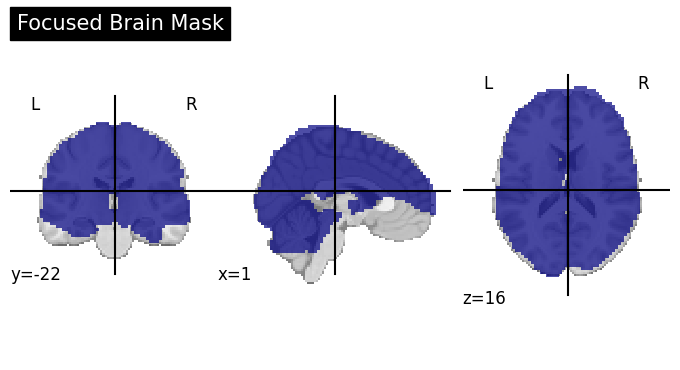

Extracting preprocessed time series...
Preprocessed time series shape: (128, 56137)
Creating TR-by-TR labels from events...
Label mapping: {0: 'audio_computation', 1: 'audio_left_hand_button_press', 2: 'audio_right_hand_button_press', 3: 'horizontal_checkerboard', 4: 'rest', 5: 'sentence_listening', 6: 'sentence_reading', 7: 'vertical_checkerboard', 8: 'visual_computation', 9: 'visual_left_hand_button_press', 10: 'visual_right_hand_button_press'}
Label distribution:
  audio_computation: 15 TRs
  audio_left_hand_button_press: 7 TRs
  audio_right_hand_button_press: 7 TRs
  horizontal_checkerboard: 12 TRs
  rest: 27 TRs
  sentence_listening: 13 TRs
  sentence_reading: 11 TRs
  vertical_checkerboard: 12 TRs
  visual_computation: 11 TRs
  visual_left_hand_button_press: 7 TRs
  visual_right_hand_button_press: 6 TRs


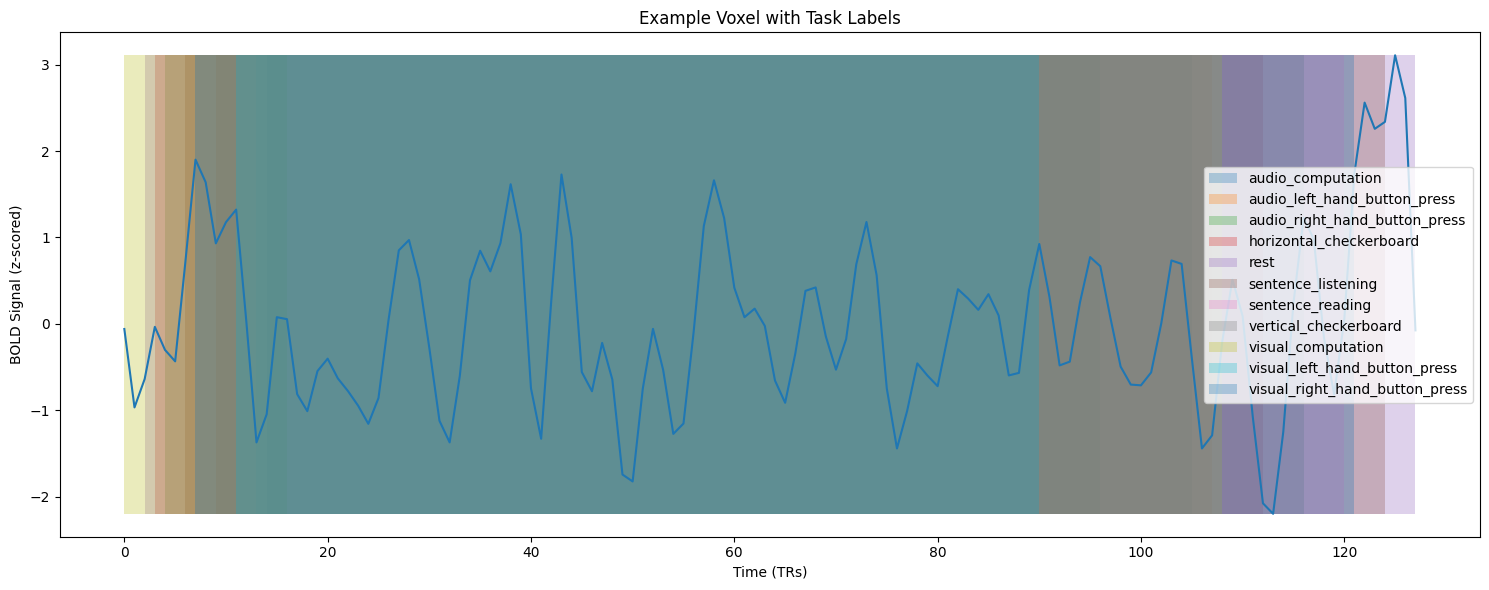

In [ ]:
# Block 4: Data Preprocessing for Localizer Dataset
#
# This block preprocesses the Localizer fMRI data and creates labels

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from nilearn.input_data import NiftiMasker

# Create a more focused brain mask to reduce dimensionality
print("Creating a more focused brain mask...")
# Apply stricter threshold to get a more focused mask
focused_mask = image.math_img('img > 0.5 * np.max(img)', img=mean_img)
plotting.plot_roi(focused_mask, title="Focused Brain Mask")
plt.show()

# Extract time series with the focused mask and additional preprocessing
print("Extracting preprocessed time series...")
masker = NiftiMasker(
    mask_img=focused_mask,
    standardize=True,       # Z-score normalization
    detrend=True,           # Remove linear trends
    high_pass=0.01,         # High-pass filter (remove slow drifts)
    low_pass=0.1,           # Low-pass filter (focus on task-relevant frequencies)
    t_r=t_r                 # Repetition time
)
time_series_preprocessed = masker.fit_transform(func_img)
print(f"Preprocessed time series shape: {time_series_preprocessed.shape}")

# Create labels based on events
# For each TR, determine which event is active (if any)
print("Creating TR-by-TR labels from events...")
n_trs = time_series_preprocessed.shape[0]
TR_times = np.arange(n_trs) * t_r
labels = np.full(n_trs, 'rest', dtype=object)  # Default label is 'rest'

# Fill in task labels
for _, row in events.iterrows():
    onset = row['onset']
    duration = row['duration']
    condition = row['trial_type']

    # Find TRs that correspond to this event
    start_tr = int(onset / t_r)
    end_tr = int((onset + duration) / t_r) + 1  # +1 to include the last TR

    # Ensure indices are within bounds
    start_tr = max(0, start_tr)
    end_tr = min(n_trs, end_tr)

    # Label these TRs
    if start_tr < end_tr:  # Make sure the interval is valid
        labels[start_tr:end_tr] = condition

# Convert string labels to numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
label_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}

print(f"Label mapping: {label_mapping}")
print(f"Label distribution:")
unique_labels, counts = np.unique(y, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  {label_mapping[label]}: {count} TRs")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(time_series_preprocessed)

# Plot example data with labels
plt.figure(figsize=(15, 6))
example_voxel = 0  # First voxel
plt.plot(X_scaled[:, example_voxel])

# Highlight different conditions with colors
for label_idx in np.unique(y):
    mask = y == label_idx
    if np.any(mask):
        plt.fill_between(
            np.arange(len(mask))[mask],
            min(X_scaled[:, example_voxel]),
            max(X_scaled[:, example_voxel]),
            alpha=0.3,
            label=label_mapping[label_idx]
        )

plt.legend()
plt.title('Example Voxel with Task Labels')
plt.xlabel('Time (TRs)')
plt.ylabel('BOLD Signal (z-scored)')
plt.tight_layout()
plt.show()

Visualizing fixed positional encoding:


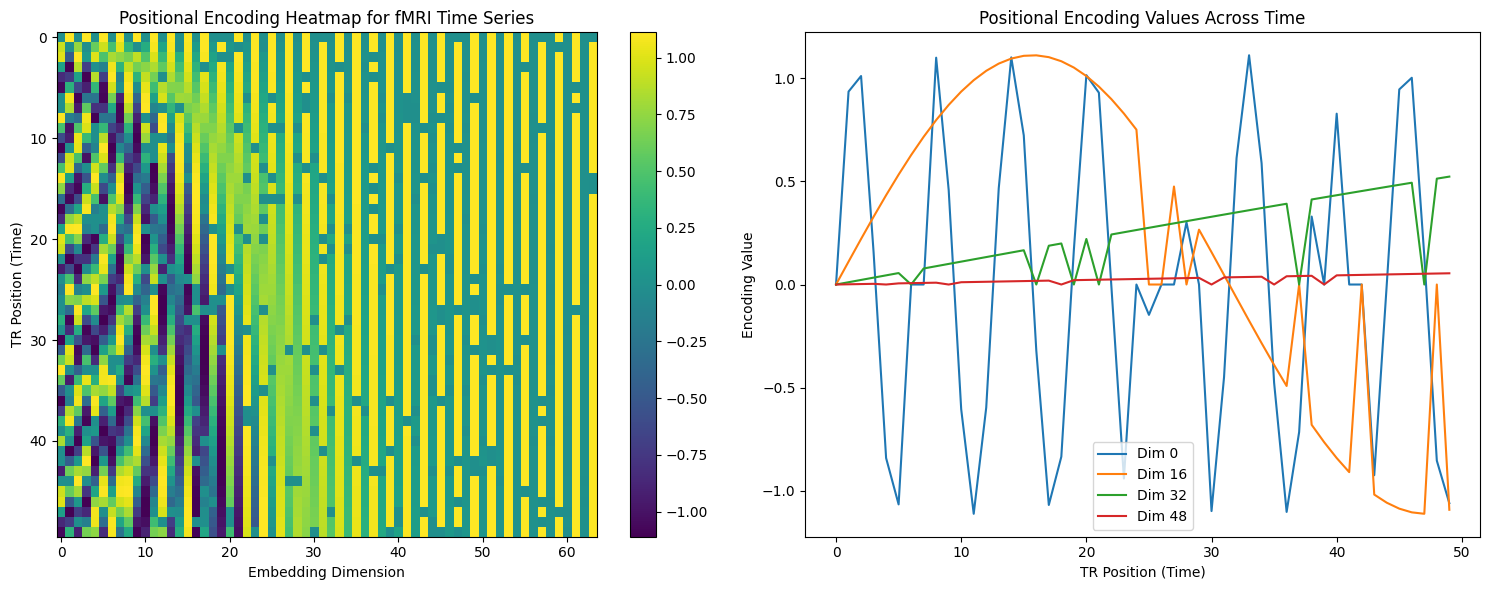

In [ ]:
# Block 5: Positional Encoding Implementation
#
# This helps the transformer model understand the temporal ordering of fMRI volumes

import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt

class PositionalEncoding(nn.Module):
    """
    Positional encoding for fMRI time series data in transformer models.
    """
    def __init__(self, d_model, max_seq_length=5000, dropout=0.1, learnable=False):
        """
        Initialize positional encoding

        Args:
            d_model: Dimension of the model
            max_seq_length: Maximum sequence length (number of TRs in fMRI)
            dropout: Dropout rate
            learnable: Whether to use learnable position embeddings
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Learnable or fixed positional embeddings
        if learnable:
            # Learnable positional embeddings
            self.pe = nn.Parameter(torch.zeros(1, max_seq_length, d_model))
            nn.init.kaiming_normal_(self.pe)
        else:
            # Fixed sinusoidal embeddings
            pe = torch.zeros(max_seq_length, d_model)
            position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

            # Apply sine to even indices
            pe[:, 0::2] = torch.sin(position * div_term)

            # Apply cosine to odd indices
            pe[:, 1::2] = torch.cos(position * div_term)

            # Add batch dimension and register as buffer (not a parameter)
            pe = pe.unsqueeze(0)
            self.register_buffer('pe', pe)

        self.learnable = learnable

    def forward(self, x):
        """
        Add positional encoding to input tensor

        Args:
            x: Input tensor [batch_size, seq_length, d_model]
                for fMRI: batch=batch_size, seq_length=time points, d_model=features

        Returns:
            Tensor with positional encoding added
        """
        # Select relevant portion of positional encoding
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Function to visualize positional encoding
def plot_positional_encoding(pe_module, seq_length=100, d_model=128):
    """
    Visualize positional encoding patterns
    """
    # Create dummy input to extract positional encoding
    dummy_input = torch.zeros(1, seq_length, d_model)
    pe = pe_module(dummy_input)[0].detach().cpu().numpy()

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(pe, aspect='auto', cmap='viridis')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('TR Position (Time)')
    plt.title('Positional Encoding Heatmap for fMRI Time Series')
    plt.colorbar()

    # Plot a few dimensions
    plt.subplot(1, 2, 2)
    plt.plot(pe[:, 0:64:16])
    plt.xlabel('TR Position (Time)')
    plt.ylabel('Encoding Value')
    plt.title('Positional Encoding Values Across Time')
    plt.legend([f'Dim {i}' for i in range(0, 64, 16)])
    plt.tight_layout()
    plt.show()

# Create and visualize positional encoding
d_model = 64  # Smaller dimension for visualization
pe_fixed = PositionalEncoding(d_model=d_model, learnable=False)
pe_learnable = PositionalEncoding(d_model=d_model, learnable=True)

# Visualize fixed positional encoding
print("Visualizing fixed positional encoding:")
plot_positional_encoding(pe_fixed, seq_length=50, d_model=d_model)

In [ ]:
# Block 6: Transformer Encoder Implementation
#
# This implements the core transformer encoder with self-attention

import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesTransformerEncoder(nn.Module):
    """
    Transformer encoder block for fMRI time series.
    """
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        """
        Initialize transformer encoder

        Args:
            d_model: Model dimension
            nhead: Number of attention heads
            dim_feedforward: Dimension of feedforward network
            dropout: Dropout rate
        """
        super(TimeSeriesTransformerEncoder, self).__init__()

        # Multi-head self-attention
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        # Feedforward network
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Store attention weights for visualization
        self.attention_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        Forward pass through encoder block

        Args:
            src: Input tensor [batch_size, seq_length, d_model]
                For fMRI: batch_size=batch, seq_length=TRs, d_model=features
            src_mask: Optional attention mask
            src_key_padding_mask: Optional mask for padded elements

        Returns:
            Processed tensor after self-attention and feedforward
        """
        # Multi-head self-attention - identifies temporal relationships in fMRI data
        attn_output, attn_weights = self.self_attn(
            query=src,
            key=src,
            value=src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True
        )

        # Store attention weights for visualization
        self.attention_weights = attn_weights

        # Add & Norm (residual connection and normalization)
        src = src + self.dropout(attn_output)
        src = self.norm1(src)

        # Feedforward network
        ff_output = self.feed_forward(src)

        # Add & Norm (residual connection and normalization)
        src = src + self.dropout(ff_output)
        src = self.norm2(src)

        return src

In [ ]:
# Block 7: Full Transformer Model for fMRI Time Series
#
# This implements the complete transformer model for fMRI time series analysis

import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    """
    Transformer model for fMRI time series classification
    """
    def __init__(self,
                 input_dim,
                 d_model=64,
                 nhead=4,
                 num_layers=2,
                 dim_feedforward=128,
                 dropout=0.2,
                 num_classes=11,  # Updated for Localizer dataset
                 max_seq_length=500,
                 learnable_pos=False):
        """
        Initialize transformer model for fMRI data

        Args:
            input_dim: Number of input features
            d_model: Model dimension
            nhead: Number of attention heads
            num_layers: Number of transformer layers
            dim_feedforward: Dimension of feedforward network
            dropout: Dropout rate
            num_classes: Number of output classes (task conditions)
            max_seq_length: Maximum sequence length (TRs in fMRI run)
            learnable_pos: Whether to use learnable positional encoding
        """
        super(TimeSeriesTransformer, self).__init__()

        # Project input features to d_model dimensions
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding for fMRI time points
        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            max_seq_length=max_seq_length,
            dropout=dropout,
            learnable=learnable_pos
        )

        # Transformer encoder layers
        self.transformer_encoders = nn.ModuleList([
            TimeSeriesTransformerEncoder(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ) for _ in range(num_layers)
        ])

        # Classification head for fMRI task conditions
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, x, mask=None):
        """
        Forward pass through transformer

        Args:
            x: Input tensor [batch_size, seq_length, input_dim]
               For fMRI: batch_size=batch, seq_length=TRs, input_dim=features
            mask: Optional attention mask

        Returns:
            Classification logits and attention weights
        """
        # Project input to model dimension
        x = self.input_projection(x)

        # Add positional encoding to represent TR order
        x = self.pos_encoder(x)

        # Apply transformer encoder layers
        attention_weights = []
        for encoder in self.transformer_encoders:
            x = encoder(x, src_mask=mask)
            attention_weights.append(encoder.attention_weights)

        # Global average pooling over sequence dimension (time)
        x = torch.mean(x, dim=1)

        # Classification of fMRI task conditions
        logits = self.classifier(x)

        return logits, attention_weights

    def get_attention_weights(self, x, mask=None):
        """
        Get attention weights for visualization

        Args:
            x: Input tensor
            mask: Optional attention mask

        Returns:
            List of attention weights from each layer
        """
        with torch.no_grad():
            _, attention_weights = self.forward(x, mask)
        return attention_weights

In [ ]:
#Block8:
# LSTM Baseline Implementation for fMRI Analysis
#
# This implements an LSTM model for comparison with the transformer,
# including an optional attention mechanism.

class LSTMAttention(nn.Module):
    """
    Attention mechanism for LSTM outputs, adapted for fMRI time series
    """
    def __init__(self, hidden_size):
        super(LSTMAttention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        """
        Apply attention to LSTM output sequence of fMRI time points

        Args:
            lstm_output: Output from LSTM [batch_size, seq_length, hidden_size]
                For fMRI: batch_size=batch, seq_length=TRs, hidden_size=hidden dim

        Returns:
            Context vector and attention weights
        """
        # Calculate attention scores for each TR
        attention_weights = self.attention(lstm_output).squeeze(-1)
        attention_weights = F.softmax(attention_weights, dim=1)

        # Apply attention to create context vector
        context = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)

        return context, attention_weights

class LSTMBaseline(nn.Module):
    """
    LSTM baseline model for fMRI time series classification
    """
    def __init__(self,
                 input_dim,
                 hidden_dim=100,
                 num_layers=2,
                 dropout=0.1,
                 bidirectional=True,
                 num_classes=5,
                 use_attention=True):
        """
        Initialize LSTM model for fMRI data

        Args:
            input_dim: Number of input features (PCA components)
            hidden_dim: Hidden dimension of LSTM
            num_layers: Number of LSTM layers
            dropout: Dropout rate
            bidirectional: Whether to use bidirectional LSTM
            num_classes: Number of output classes (stimulus categories)
            use_attention: Whether to use attention mechanism
        """
        super(LSTMBaseline, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.use_attention = use_attention

        # LSTM layer for processing fMRI time series
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Attention mechanism for identifying important TRs
        if use_attention:
            self.attention = LSTMAttention(hidden_dim * 2 if bidirectional else hidden_dim)

        # Output dimension depends on bidirectionality
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Classification head for fMRI stimulus categories
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        """
        Forward pass through LSTM model

        Args:
            x: Input tensor [batch_size, seq_length, input_dim]
                For fMRI: batch_size=batch, seq_length=TRs, input_dim=PCA components

        Returns:
            Classification logits and attention weights (if applicable)
        """
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)

        attention_weights = None

        # Apply attention or use last hidden state
        if self.use_attention:
            context, attention_weights = self.attention(lstm_out)
            output = self.classifier(context)
        else:
            # Use last time step
            output = self.classifier(lstm_out[:, -1, :])

        return output, attention_weights

In [ ]:
# Block 9: Dataset Preparation for fMRI Analysis
#
# This block prepares the fMRI data for training by:
# 1. Applying dimensionality reduction
# 2. Splitting into train/validation/test sets
# 3. Creating sequences with sliding windows
# 4. Setting up PyTorch datasets and dataloaders

# Apply dimensionality reduction with PCA
from sklearn.decomposition import PCA

print("Applying PCA for dimensionality reduction...")
# Determine number of components (e.g., 95% of variance or fixed number)
pca = PCA(n_components=50)  # Adjust based on your dataset
X_reduced = pca.fit_transform(X_scaled)
print(f"Reduced dimensions from {X_scaled.shape[1]} to {X_reduced.shape[1]} features")
print(f"Variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Define TR (repetition time) for later use in visualization
TR = 2.4  # seconds

# Define class names based on label mapping
class_names = [label_mapping[i] for i in range(len(label_mapping))]
print(f"Class names: {class_names}")

# Split the data into train, validation, and test sets
# Use stratified splitting to maintain class distribution
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} time points")
print(f"Validation set: {X_val.shape[0]} time points")
print(f"Test set: {X_test.shape[0]} time points")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

# Function to create sequences for time-series analysis
def create_sequences(X, y, seq_length=10):
    """
    Create sequences from fMRI time series using sliding window

    Args:
        X: fMRI time series data [time points, features]
        y: Labels [time points]
        seq_length: Sequence length (window size in TRs)

    Returns:
        Sequences and corresponding labels
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_length + 1):
        Xs.append(X[i:i+seq_length])
        # Use the label of the last TR in the sequence
        ys.append(y[i+seq_length-1])
    return torch.stack(Xs), torch.tensor(ys)

# Find the smallest dataset size
min_size = min(len(X_train_tensor), len(X_val_tensor), len(X_test_tensor))
print(f"Smallest dataset size: {min_size} time points")

# Choose a sequence length that works for all datasets
seq_length = min_size - 5  # Give some buffer for safety
seq_length = max(5, min(15, seq_length))  # Keep between 5 and 15 for reasonable analysis
print(f"Creating sequences with length {seq_length} TRs ({seq_length * TR:.1f} seconds)...")

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_tensor, y_train_tensor, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val_tensor, y_val_tensor, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_tensor, y_test_tensor, seq_length)

print(f"Training sequences: {X_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_seq, y_train_seq)
val_dataset = TensorDataset(X_val_seq, y_val_seq)
test_dataset = TensorDataset(X_test_seq, y_test_seq)

# Adjust batch size to be no larger than the smallest dataset
batch_size = min(32, len(train_dataset), len(val_dataset), len(test_dataset))
print(f"Using batch size: {batch_size}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Peek at a batch
X_batch, y_batch = next(iter(train_loader))
print(f"Batch shape: {X_batch.shape} [batch_size, seq_length, features]")
print(f"Labels shape: {y_batch.shape}")

Applying PCA for dimensionality reduction...
Reduced dimensions from 56137 to 50 features
Variance explained: 0.9680
Class names: ['audio_computation', 'audio_left_hand_button_press', 'audio_right_hand_button_press', 'horizontal_checkerboard', 'rest', 'sentence_listening', 'sentence_reading', 'vertical_checkerboard', 'visual_computation', 'visual_left_hand_button_press', 'visual_right_hand_button_press']
Training set: 89 time points
Validation set: 19 time points
Test set: 20 time points
Smallest dataset size: 19 time points
Creating sequences with length 14 TRs (33.6 seconds)...
Training sequences: torch.Size([76, 14, 50])
Validation sequences: torch.Size([6, 14, 50])
Test sequences: torch.Size([7, 14, 50])
Using batch size: 6
Batch shape: torch.Size([6, 14, 50]) [batch_size, seq_length, features]
Labels shape: torch.Size([6])


Input dimensions: 50 features
Number of classes: 11
Sequence length: 14 TRs
Initializing models...
Training for 20 epochs...
Training transformer model...
Epoch 1/20 | Train Loss: 2.4351 | Train Acc: 5.26% | Val Loss: 2.3385 | Val Acc: 16.67%
Epoch 2/20 | Train Loss: 2.3499 | Train Acc: 11.84% | Val Loss: 2.4002 | Val Acc: 0.00%
Epoch 3/20 | Train Loss: 2.3199 | Train Acc: 18.42% | Val Loss: 2.4519 | Val Acc: 0.00%
Epoch 4/20 | Train Loss: 2.2779 | Train Acc: 26.32% | Val Loss: 2.5325 | Val Acc: 0.00%
Epoch 5/20 | Train Loss: 2.2222 | Train Acc: 27.63% | Val Loss: 2.5380 | Val Acc: 0.00%
Epoch 6/20 | Train Loss: 2.1503 | Train Acc: 27.63% | Val Loss: 2.6323 | Val Acc: 0.00%
Epoch 7/20 | Train Loss: 2.1383 | Train Acc: 27.63% | Val Loss: 2.5851 | Val Acc: 0.00%
Epoch 8/20 | Train Loss: 2.1309 | Train Acc: 28.95% | Val Loss: 2.6039 | Val Acc: 0.00%
Epoch 9/20 | Train Loss: 2.0916 | Train Acc: 31.58% | Val Loss: 2.4670 | Val Acc: 0.00%
Epoch 10/20 | Train Loss: 2.1090 | Train Acc: 31.58% 

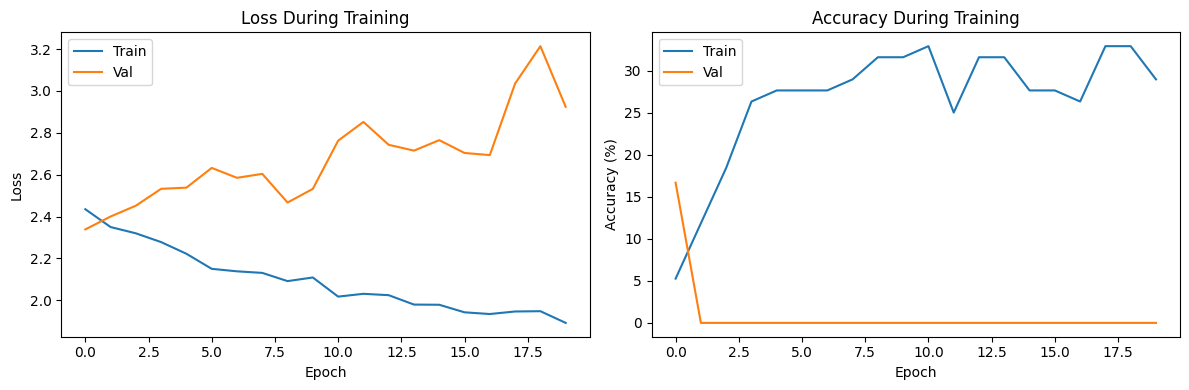

In [ ]:
# Block 9.5: Model Definition and Training
#
# This block defines and trains the transformer model

# Get input dimensions from the processed data
input_dim = X_train_seq.shape[2]  # Number of features after PCA
num_classes = len(class_names)     # Number of unique task conditions
seq_length = X_train_seq.shape[1]  # Sequence length

print(f"Input dimensions: {input_dim} features")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {seq_length} TRs")

# Initialize models
print("Initializing models...")
transformer = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,          # Embedding dimension
    nhead=4,             # Number of attention heads
    num_layers=2,        # Number of transformer layers
    dim_feedforward=128, # Feedforward network dimension
    dropout=0.2,
    num_classes=num_classes,
    max_seq_length=seq_length,
    learnable_pos=False
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# Training function
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / total
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

# Training loop
num_epochs = 20
print(f"Training for {num_epochs} epochs...")

# For tracking training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Train transformer
print("Training transformer model...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(transformer, train_loader, criterion, optimizer)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validate
    val_loss, val_acc = validate(transformer, val_loader, criterion)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Evaluate on test set
transformer.eval()
test_loss, test_acc = validate(transformer, test_loader, criterion)
print(f"\nTransformer Test Accuracy: {test_acc:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Visualizing attention for audio_computation sample:
True class: audio_computation (Class 0)
Predicted class: rest (Class 4)


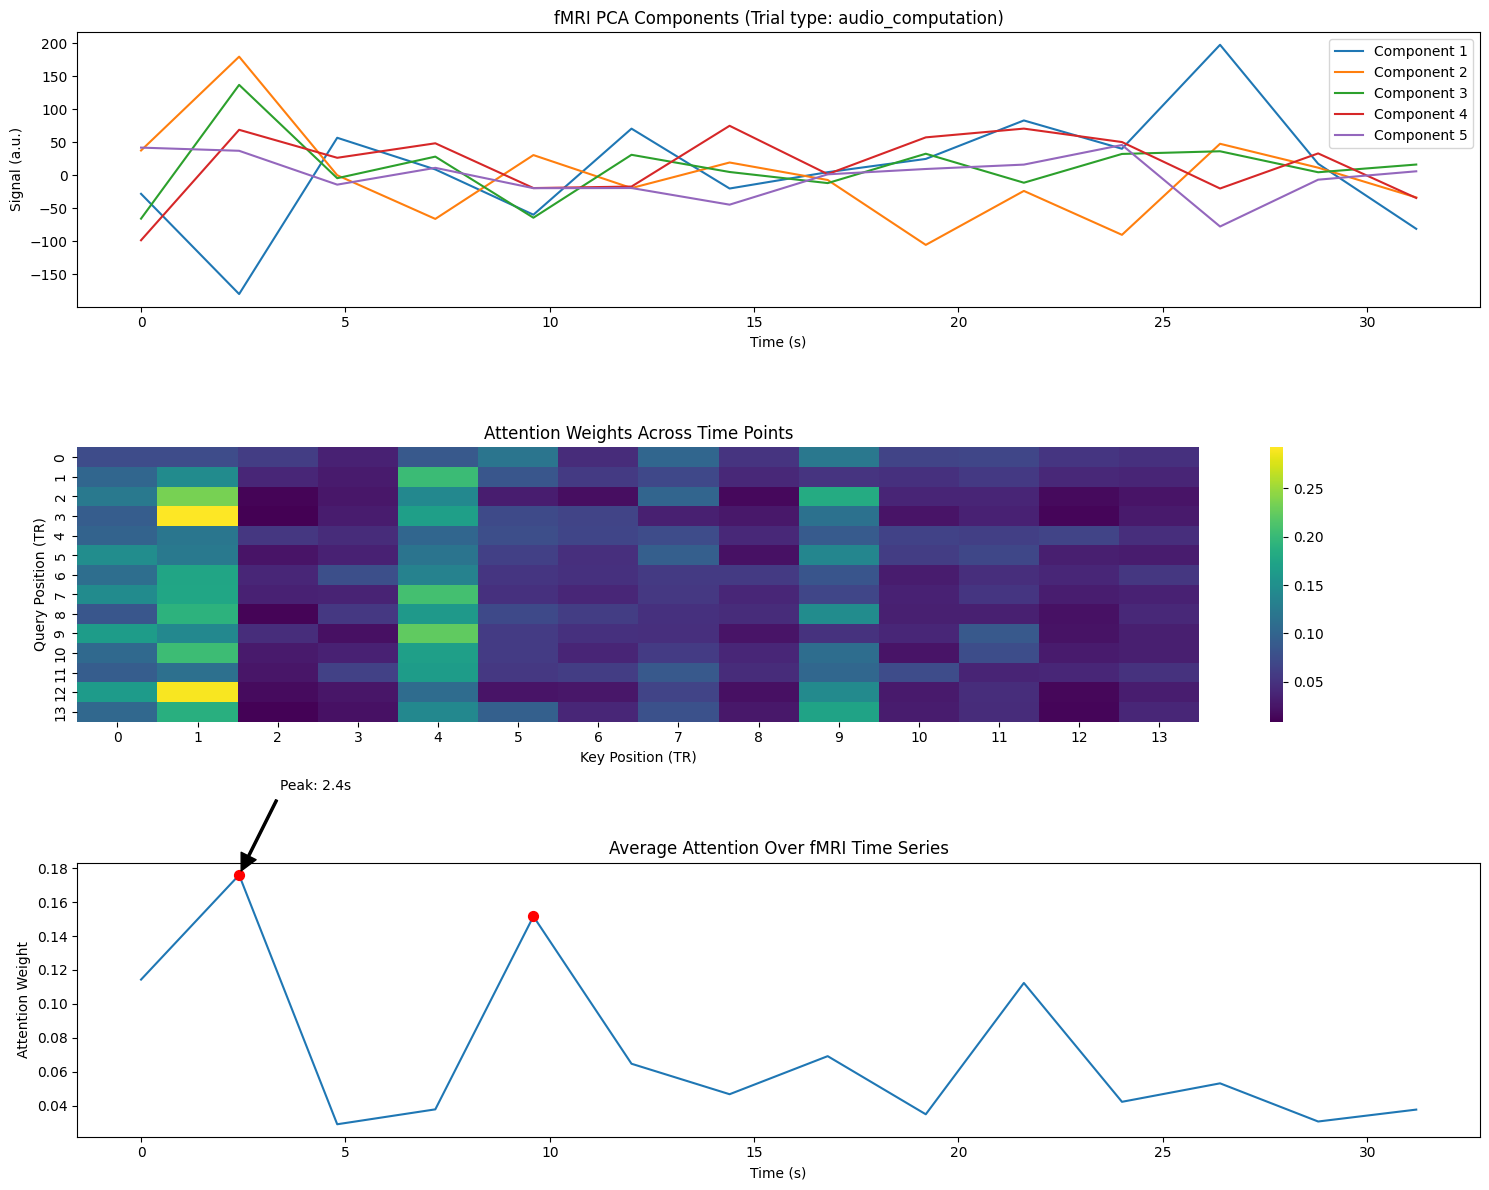


Visualizing attention for audio_left_hand_button_press sample:
True class: audio_left_hand_button_press (Class 1)
Predicted class: rest (Class 4)


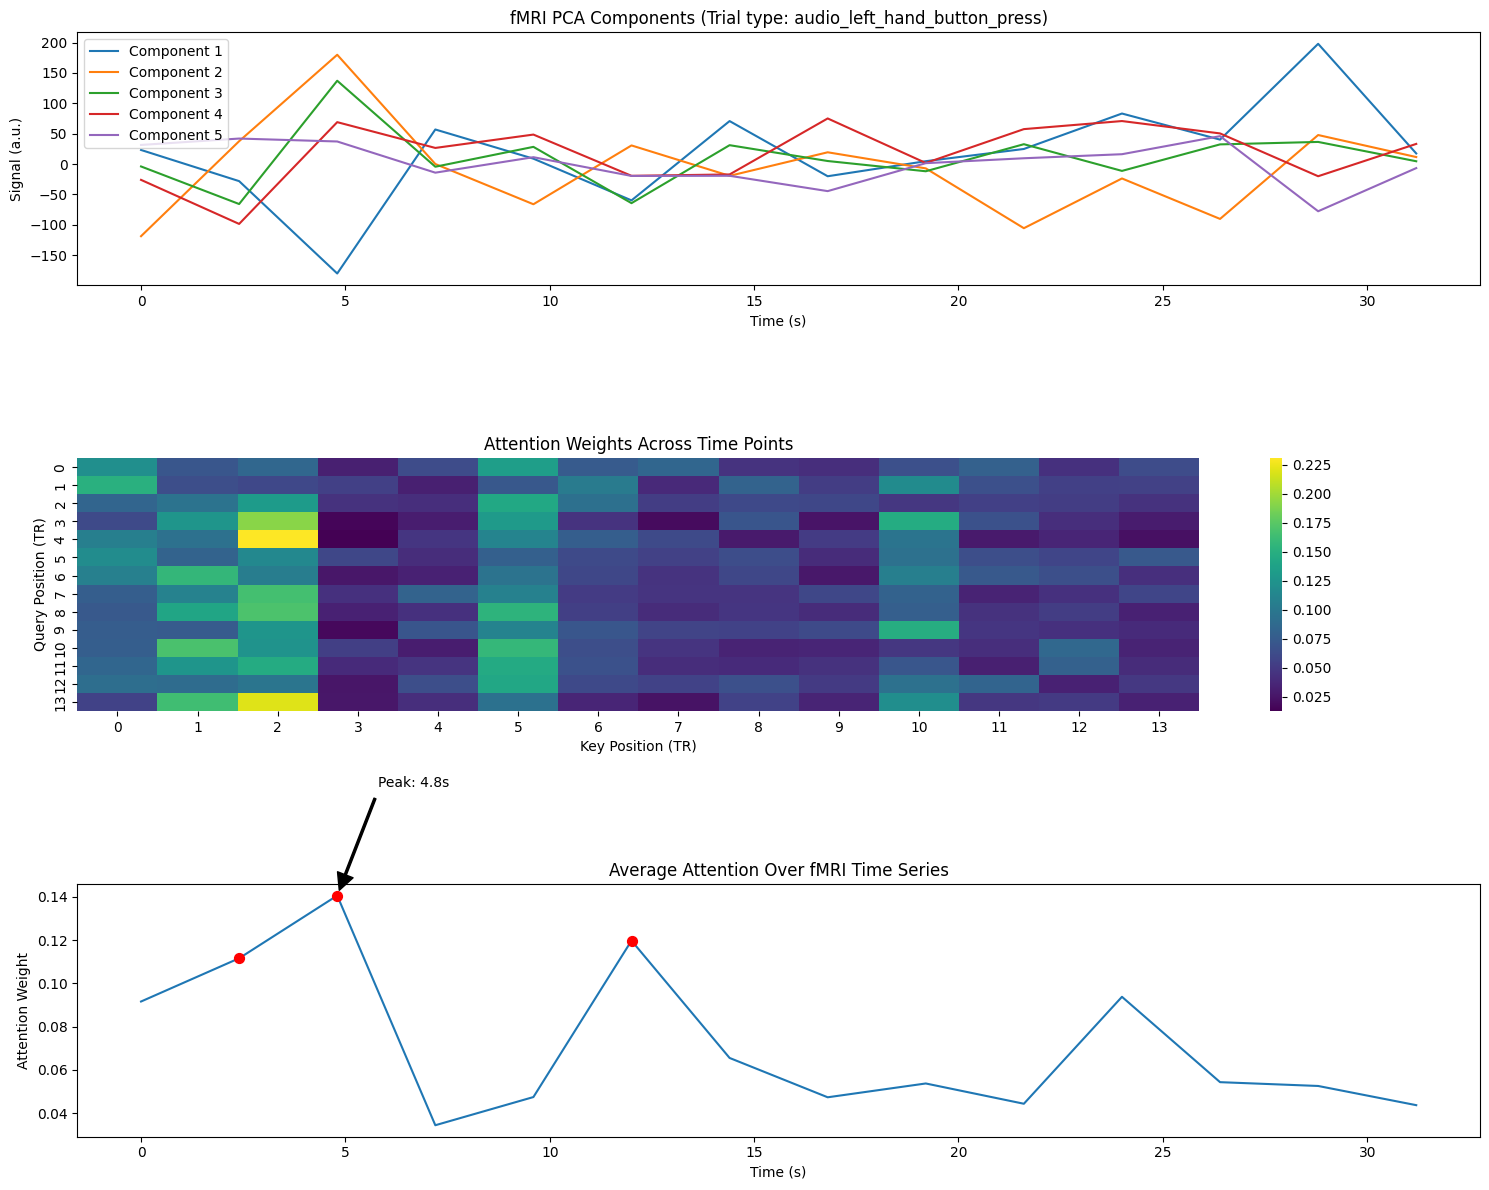


Visualizing attention for rest sample:
True class: rest (Class 4)
Predicted class: rest (Class 4)


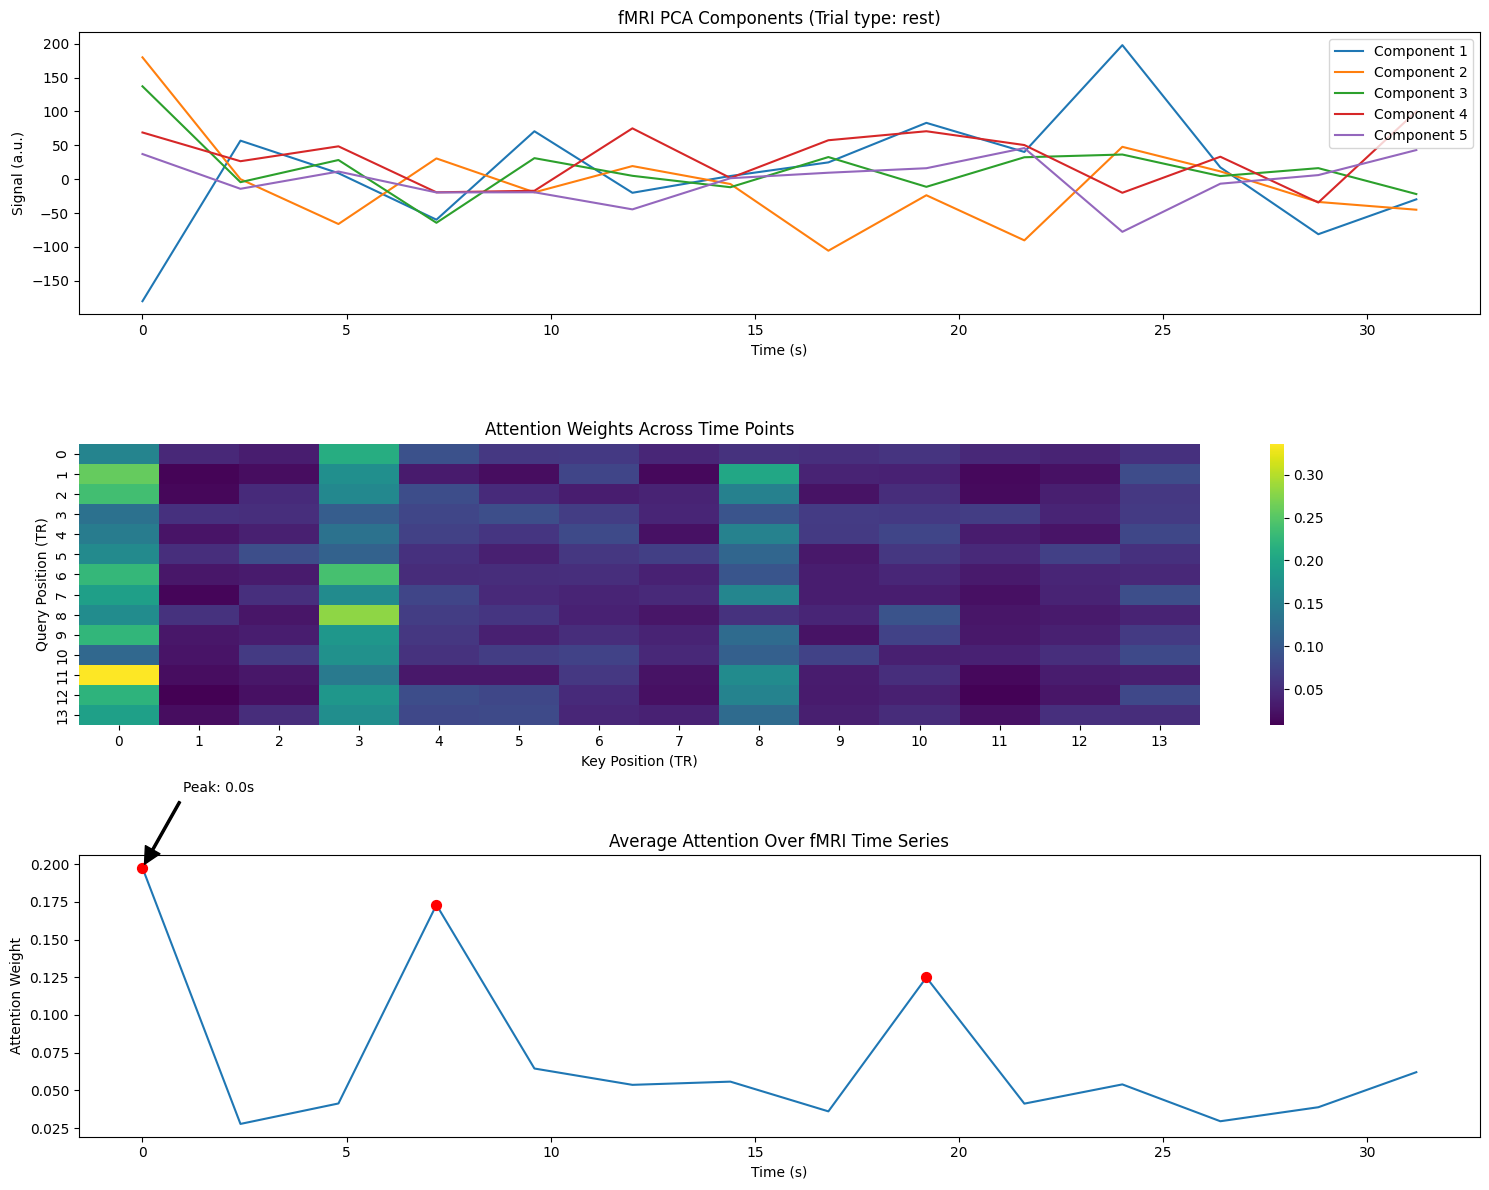


Number of correctly classified samples: 1
Number of misclassified samples: 6

Attention pattern for a correctly classified sample:
True class: rest (Class 4)
Predicted class: rest (Class 4)


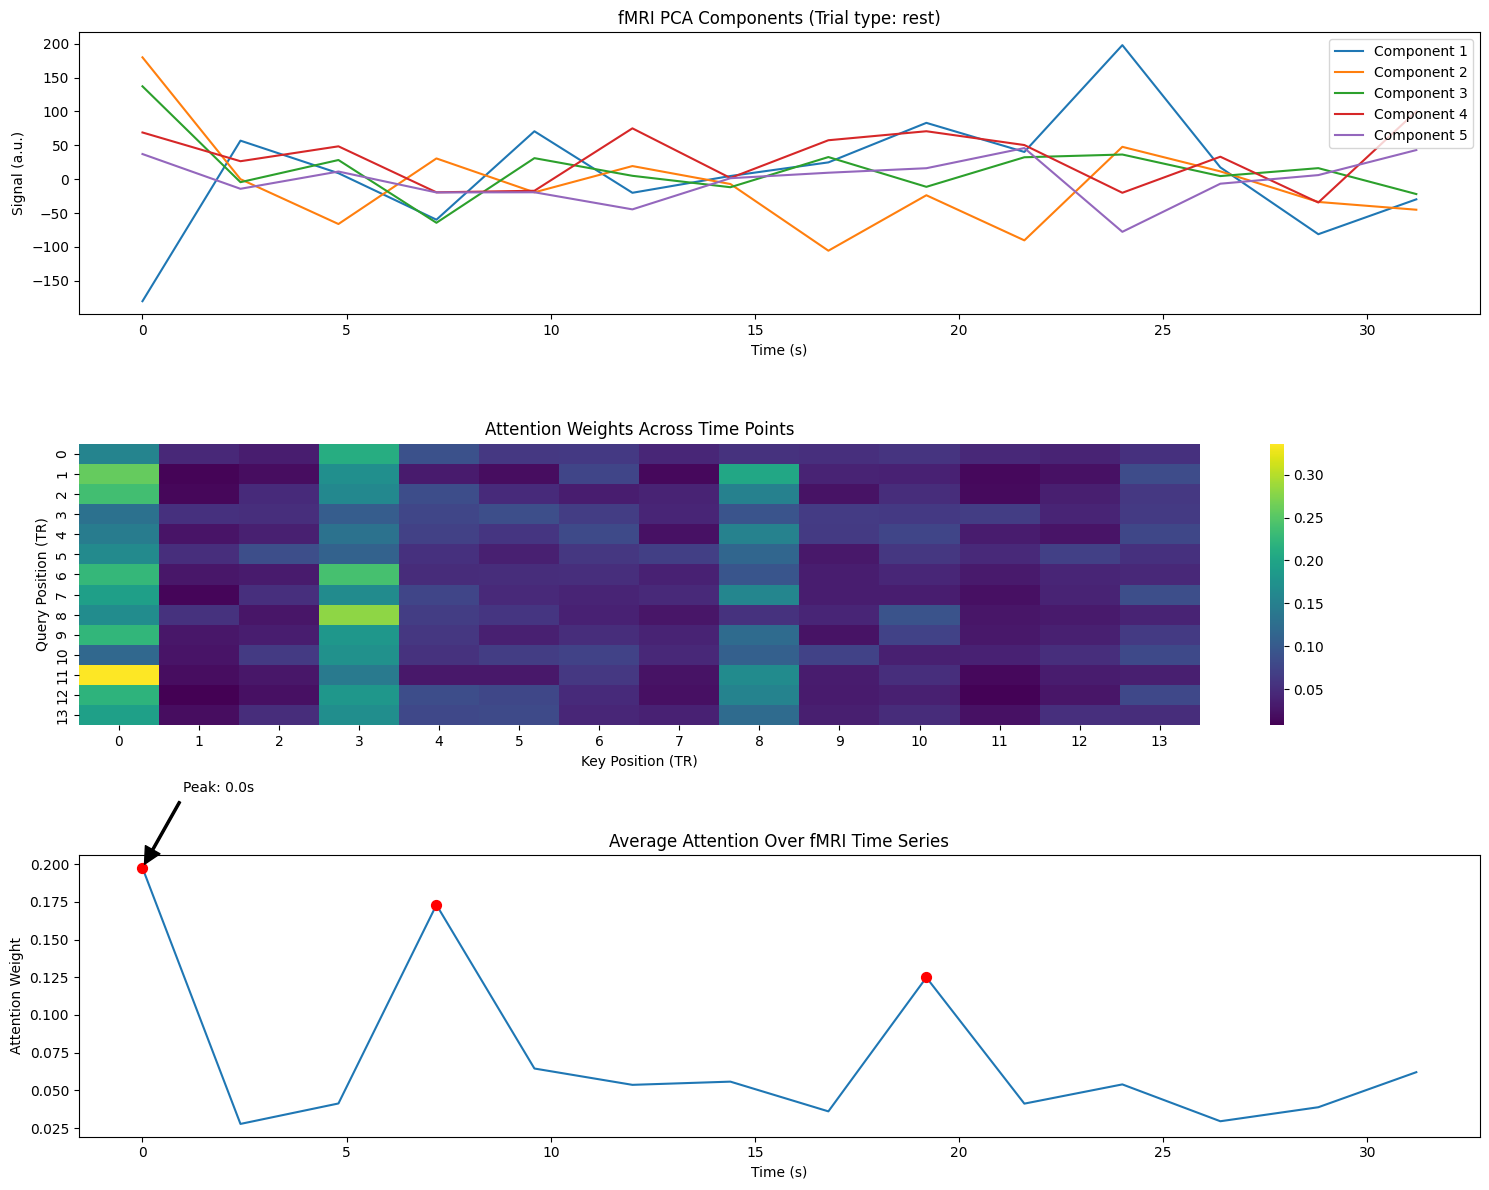


Attention pattern for an incorrectly classified sample:
True class: visual_computation (Class 8)
Predicted class: rest (Class 4)


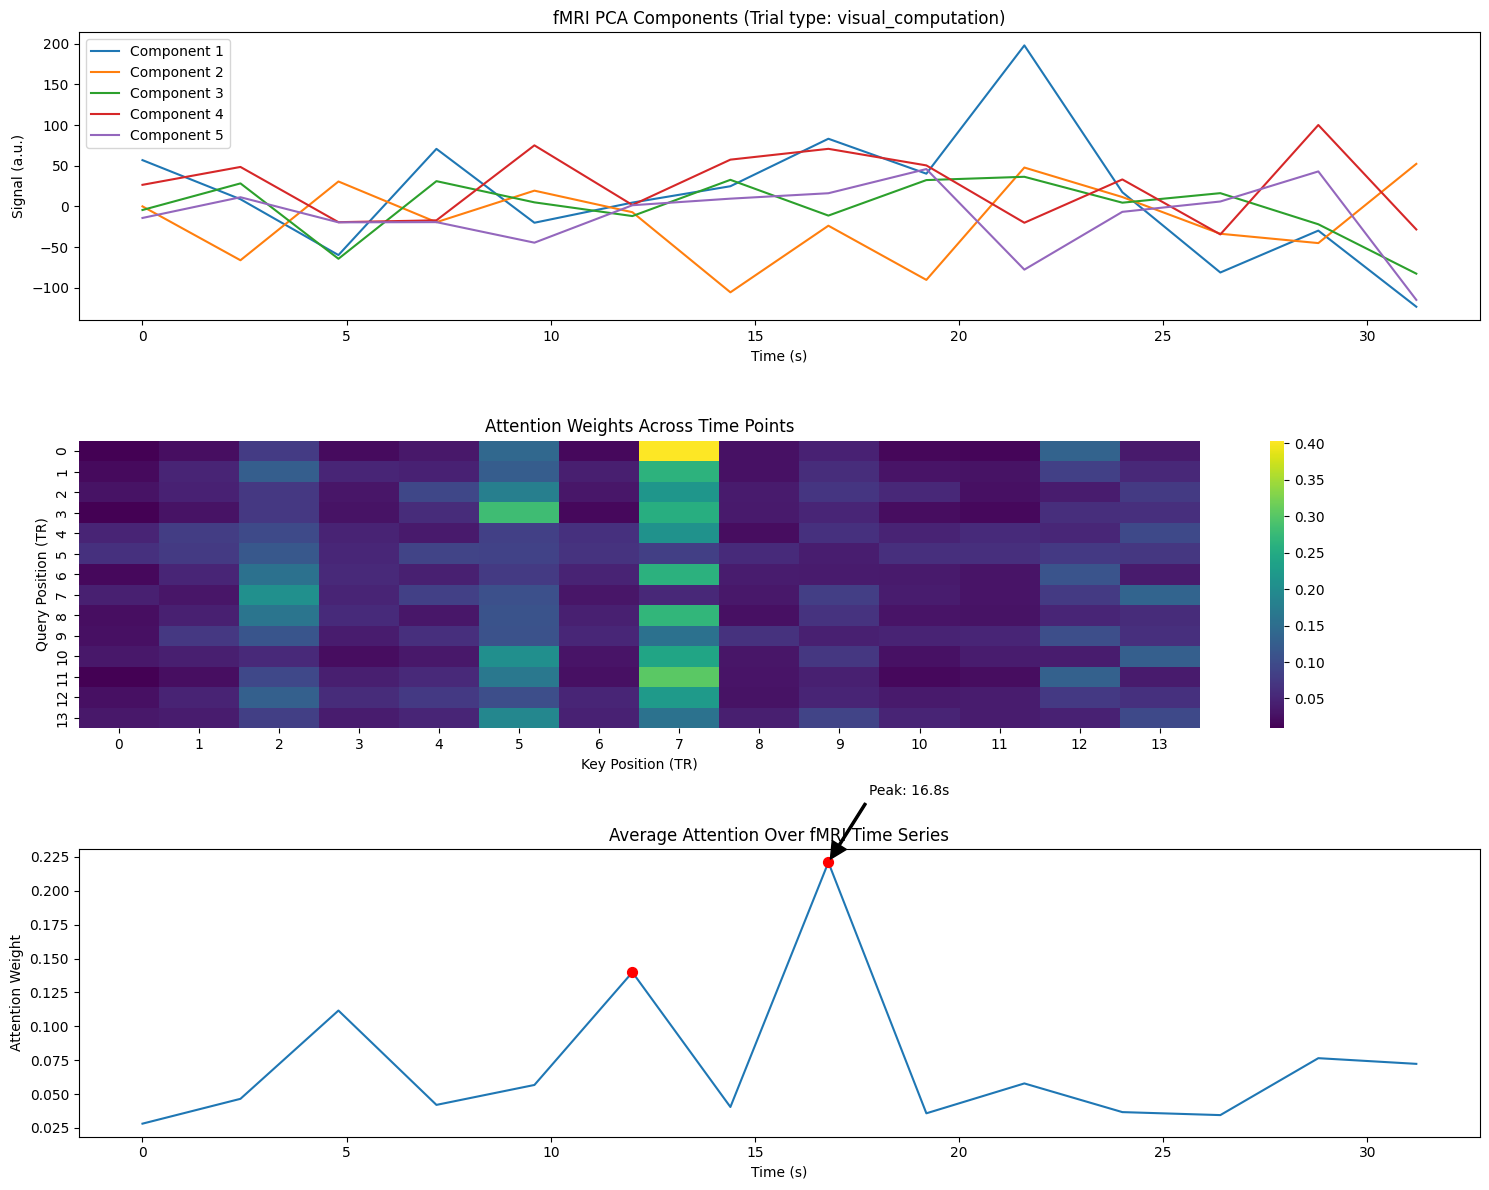

In [ ]:
# Block 10: Attention Visualization for Localizer fMRI Data
#
# This block visualizes attention patterns from the transformer model
# to identify important timepoints in the fMRI data

def visualize_attention(model, input_data, target, sample_idx, trial_type=None):
    """
    Visualize attention patterns from transformer model for fMRI data

    Args:
        model: Trained transformer model
        input_data: Input tensor
        target: Target class
        sample_idx: Index of sample to visualize
        trial_type: Optional trial type name for the title
    """
    model.eval()

    # Select a sample
    sample = input_data[sample_idx].unsqueeze(0).to(device)

    # Get model prediction and attention weights
    with torch.no_grad():
        outputs, attn_weights = model(sample)
        _, predicted = outputs.max(1)

    predicted_class = predicted.item()
    true_class = target[sample_idx].item()

    predicted_name = class_names[predicted_class]
    true_name = class_names[true_class]

    title_suffix = f" (Trial type: {trial_type})" if trial_type else ""

    print(f"True class: {true_name} (Class {true_class})")
    print(f"Predicted class: {predicted_name} (Class {predicted_class})")

    # Get attention weights from the last layer
    last_layer_attn = attn_weights[-1].squeeze().cpu().numpy()

    # Create time points for x-axis (in seconds)
    time_points = np.arange(seq_length) * TR  # TR = 2.4s

    # Plot attention visualization
    plt.figure(figsize=(15, 12))

    # Plot input fMRI time series (first 5 components)
    plt.subplot(3, 1, 1)
    for i in range(min(5, sample.size(2))):
        plt.plot(time_points, sample[0, :, i].cpu().numpy(), label=f'Component {i+1}')
    plt.title(f'fMRI PCA Components{title_suffix}')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal (a.u.)')
    plt.legend()

    # Plot attention heatmap
    plt.subplot(3, 1, 2)
    sns.heatmap(last_layer_attn, cmap='viridis')
    plt.title('Attention Weights Across Time Points')
    plt.xlabel('Key Position (TR)')
    plt.ylabel('Query Position (TR)')

    # Plot average attention over time
    plt.subplot(3, 1, 3)

    # Average attention across queries (rows)
    avg_attention = last_layer_attn.mean(axis=0)

    plt.plot(time_points, avg_attention)
    plt.title('Average Attention Over fMRI Time Series')
    plt.xlabel('Time (s)')
    plt.ylabel('Attention Weight')

    # Highlight regions with high attention
    threshold = avg_attention.mean() + avg_attention.std()
    high_attention_indices = np.where(avg_attention > threshold)[0]

    if len(high_attention_indices) > 0:
        plt.scatter(time_points[high_attention_indices],
                   avg_attention[high_attention_indices],
                   color='red', s=50, zorder=3)

        # Annotate the highest attention point
        max_idx = np.argmax(avg_attention)
        plt.annotate(f'Peak: {time_points[max_idx]:.1f}s',
                    xy=(time_points[max_idx], avg_attention[max_idx]),
                    xytext=(time_points[max_idx]+1, avg_attention[max_idx]+0.05),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.tight_layout()
    plt.show()

# Visualize attention for different stimulus conditions
for class_idx, class_name in enumerate(class_names):
    # Find samples of this class
    class_samples = np.where(y_test_seq == class_idx)[0]  # Changed from y_test_tensor to y_test_seq

    if len(class_samples) > 0:
        # Select a random sample
        sample_idx = np.random.choice(class_samples)

        print(f"\nVisualizing attention for {class_name} sample:")
        visualize_attention(transformer, X_test_seq, y_test_seq, sample_idx, class_name)  # Changed from X/y_test_tensor to X/y_test_seq
        if class_idx >= 2:  # Limit to 3 classes for brevity
            break

# Compare attention patterns between correctly and incorrectly classified samples
with torch.no_grad():
    # Get test predictions
    test_outputs, _ = transformer(X_test_seq.to(device))  # Changed from X_test_tensor to X_test_seq
    _, test_preds = test_outputs.max(1)
    test_preds = test_preds.cpu().numpy()

# Find correctly and incorrectly classified samples
correct_indices = np.where(test_preds == y_test_seq.numpy())[0]  # Changed from y_test to y_test_seq.numpy()
incorrect_indices = np.where(test_preds != y_test_seq.numpy())[0]  # Changed from y_test to y_test_seq.numpy()

print(f"\nNumber of correctly classified samples: {len(correct_indices)}")
print(f"Number of misclassified samples: {len(incorrect_indices)}")

# Visualize attention for a correct sample
if len(correct_indices) > 0:
    print("\nAttention pattern for a correctly classified sample:")
    correct_idx = np.random.choice(correct_indices)
    correct_class = class_names[y_test_seq[correct_idx]]  # Changed from y_test to y_test_seq
    visualize_attention(transformer, X_test_seq, y_test_seq, correct_idx, correct_class)  # Changed from X/y_test_tensor to X/y_test_seq

# Visualize attention for an incorrect sample
if len(incorrect_indices) > 0:
    print("\nAttention pattern for an incorrectly classified sample:")
    incorrect_idx = np.random.choice(incorrect_indices)
    incorrect_class = class_names[y_test_seq[incorrect_idx]]  # Changed from y_test to y_test_seq
    visualize_attention(transformer, X_test_seq, y_test_seq, incorrect_idx, incorrect_class)  # Changed from X/y_test_tensor to X/y_test_seq